In [0]:
!pip install tslearn

     |████████████████████████████████| 747kB 4.7MB/s 


In [0]:
!pip install sklearn

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from tslearn.utils import to_time_series_dataset

from tslearn.metrics import cdist_dtw
from tslearn.clustering import silhouette_score
# from sklearn.metrics import silhouette_score


import csv
import matplotlib.pyplot as plt
import copy 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
###############################################################
# Normalizing then Clustering
#####################################################

In [0]:
#adding data
number_of_clusters = 4
# metricOfClustering = "dtw"
metricOfClustering = "euclidean"
title = 'Kona'

with open(title +'.csv','r') as dest_f:
    data_iter = csv.reader(dest_f,
                           #delimiter = delimiter,
                           quotechar = '"')
    full_data = np.array([np.array(i_data[:25]) for i_data in data_iter])
    full_data = full_data[1:]
copyOfFull_data = copy.deepcopy(full_data)
datawithId = full_data[:, 1:23].astype(float)
data = datawithId[:, 2:23]
print("Length Of dataset",len(datawithId))

X = data[:].astype(float)
sz = X.shape[1]
############################################################################
# Transfoming data

arr_of_ind = []
for i, row in enumerate(X):
    if (sum(row < 7) + sum(row > 40)) > 10:
        arr_of_ind.append(i)

### for ID,Median, Mean CSV
copyOfFull_data = np.delete(copyOfFull_data, arr_of_ind, axis=0)
###

X = np.delete(X, arr_of_ind, axis=0)
datawithId = np.delete(datawithId, arr_of_ind, axis=0)
print("Length Of dataset after ClenUp",len(datawithId))
############################################################################
# Rolling avarage

def RollingAvarage2(array):
  copyOfArray = copy.deepcopy(array)
  for i,row in enumerate(array):
    for j,col in enumerate(row):
      if j==0:
        array[i][j] = (copyOfArray[i][j] + copyOfArray[i][j+1])/2
      elif j== len(row)-1:
        array[i][j] = (copyOfArray[i][j-1] + copyOfArray[i][j])/2
      else:
        array[i][j] = (copyOfArray[i][j-1] + copyOfArray[i][j] + copyOfArray[i][j+1])/3

  return array


def getNorm(arr):
    for row in range(0, len(arr)):
        maximumVal = 0.0
        minimumVal = 0.0
        for column in range(0, len(arr[0])):

            if column == 1:
                minimumVal = arr[row][column]
            if float(arr[row][column]) >= maximumVal:
                maximumVal = arr[row][column]
            if float(arr[row][column]) < minimumVal:
                minimumVal = arr[row][column]

        for column in range(0, len(arr[0])):
            arr[row][column] = (arr[row][column] - minimumVal) / (maximumVal - minimumVal)
            arr[row][column] = round(arr[row][column], 2)

    return arr


# print(X[0:3])
X = RollingAvarage2(X)
# print(X[0:3])
# print("datawihId")
# print(datawithId[0:3])
datawithId[:,2:] = RollingAvarage2(datawithId[:,2:])
# print(datawithId[0:3])
X = getNorm(X)

datawithId[:,2:] = getNorm(datawithId[:,2:])

############################################################################
############################################################################
#Clustering

X_bis = to_time_series_dataset(X)
X_bis_reveled = [i.ravel() for i in X_bis]

a = TimeSeriesKMeans(n_clusters=number_of_clusters, max_iter=50, metric= metricOfClustering, random_state=0, n_init = 50)
b = a.fit_predict(X_bis)

out = []
nr_clusters = np.arange(2, 15)
for k in nr_clusters:
  a = TimeSeriesKMeans(n_clusters= k, max_iter=50, metric= metricOfClustering, 
                       random_state=0, n_init = 50)
  b = a.fit_predict(X_bis)
  out.append(silhouette_score(X_bis_reveled, b, metric= metricOfClustering))
out = np.array(out)

print('max score',nr_clusters[np.argmax(out)])

print('silhouette_score',out)

# a = TimeSeriesKMeans(n_clusters =nr_clusters[np.argmax(out)], max_iter=50, metric= metricOfClustering, random_state=0, n_init = 50)
# b = a.fit_predict(X_bis)



###########################################################################
#extracting ID array from clustered data

arrayofId =[]
clusteredArray = []

def check(test,array):
  result = any(np.array_equal(x, test) for x in array)
  return result


def extractIDArray(number_of_clusters,datawithId, X):
  for i in range(number_of_clusters):
    Id = [] 
    cluster =[]
    for rowInX in datawithId:
      # print(rowInX[0].astype(int),rowInX[1:].astype(float))
      if check(rowInX[1:].astype(float), X[np.where(b == i)]):
        # print("mtnuma ifi mej")
        Id.append(str(rowInX[0].astype(int)))
        cluster.append(rowInX[1:])
    arrayofId.insert(i,Id)
    clusteredArray.insert(i,cluster)

  # print(arrayofId, clusteredArray)
  return arrayofId, clusteredArray


arrayofId, clusteredArray = extractIDArray(number_of_clusters,datawithId[:,1:], X)

############################################################################

arrayofMeta = []
dictionary = {
    "age_group": "",
    "gender": ""
}

for sub_arr in arrayofId:
  length = len(sub_arr)
  inner_arr = np.array([])

  for elem in sub_arr:
    mask = full_data[:, 2] == elem
    res = full_data[mask, [-1, -2]]
    inner_arr = np.append(inner_arr, res)
  
  
  inner_arr = inner_arr.reshape(-1, 2)
  # print(inner_arr)
  unique_age, counts_age = np.unique(inner_arr[:, 0], return_counts=True)
  unique_gender, counts_gender = np.unique(inner_arr[:, 1], return_counts=True)

  age_desc_arr = np.asarray((unique_age, counts_age)).T
  gender_desc_arr = np.asarray((unique_gender, counts_gender)).T
  appended_gender_age = np.append(age_desc_arr, gender_desc_arr, axis=0)
  arrayofMeta.append(appended_gender_age)

############################################################################
# for normalizing clustered data

clusteredArrayCopy = np.copy(clusteredArray)

normalizedClusteredArray = []

# for i in range(0,number_of_clusters):
#   normalizedClusteredArray.append(getNorm(clusteredArrayCopy[i])) 

############################################################################

normalizedClusterCenters = []

def getNorm1D(arr):
    max_value = np.max(arr)
    min_value = np.min(arr)

    for index in range(0, len(arr)):
      arr[index] = (arr[index] - min_value) / (max_value - min_value)
      arr[index] = round(arr[index], 2)

    return arr

# for i in range(number_of_clusters):
#   normalizedClusterCenters.append(getNorm1D(a.cluster_centers_[i].ravel()))

############################################################################

# normalizedClusteredArray = sorted(normalizedClusteredArray, key=lambda a: len(a), reverse=True)
def key_func(arr):
  sum = 0
  for pair_arr in arr:
    if pair_arr[0] == 'M' or pair_arr[0] == 'F':
      sum += int(pair_arr[1])
  return sum

# arrayofMeta = sorted(arrayofMeta, key=key_func, reverse=True)

############################################################################
# Ranks in clusters
arrayOfClusterRanksLocal = []
arrayOfClusterRanksKona = []

medianRankForClustersLocal = []
medianRankForClustersKona = []

for idArray in arrayofId:
  # print(idArray)
  LocalRankarray = []
  KonaRankArray = []
  for ID in idArray:
    for row in full_data:
      # if ID == row[1].astype(int):
      if ID == row[2]:
        LocalRankarray.append(row[0].astype(int))
        KonaRankArray.append(row[1].astype(int))
  arrayOfClusterRanksLocal.append(LocalRankarray)
  arrayOfClusterRanksKona.append(KonaRankArray)

for cluster in arrayOfClusterRanksLocal:
    medianRankForClustersLocal.append(np.median(cluster))
    # print(np.median(cluster))

for cluster in arrayOfClusterRanksKona:
    # print("Cluster",cluster)
    medianRankForClustersKona.append(np.median(cluster))
    # print(np.median(cluster))



#########################################################


#############################################################
# Percentages

MaleNumber = 0
FemaleNumber = 0
percentOfMale = 0
percentOfFemale = 0

for index, meta in enumerate(arrayofMeta): 
  for part in meta:
    if(part[0] == 'F'):
      FemaleNumber = FemaleNumber + meta[len(meta)-2][1].astype(int)
    if(part[0] == 'M'):
        MaleNumber = MaleNumber + meta[len(meta)-1][1].astype(int)

arrayOfPercentage = []

for index, meta in enumerate(arrayofMeta): 
  array = []

  for part in meta:
    if(part[0] == 'F'):
      percentOfFemale = (meta[len(meta)-2][1].astype(int))/FemaleNumber
      female = []
      female.append('F')
      female.append(percentOfFemale*100)
      array.append(female)
    if(part[0] == 'M'):
      male = [] 
      percentOfMale = (meta[len(meta)-1][1].astype(int))/MaleNumber
      male.append('M')
      male.append(percentOfMale*100)
      array.append(male)
       
  arrayOfPercentage.append(array) 
##############################################################################

full_Id_List = []
for array in arrayofId:
  for id in array:
    full_Id_List.append(id)

inner_array = np.array([])
for ID in full_Id_List:
  maskValue = full_data[:, 2] == ID
  resValue = full_data[maskValue, [-1, -1]]
  inner_array = np.append(inner_array, resValue)

inner_Value = inner_array.reshape(-1, 2)
unique_ages, counts_ages = np.unique(inner_Value[:, -2], return_counts=True)
# print(unique_ages,counts_ages)


#######################################################################
percentageOfAgeGroups = []
for age, count in zip(unique_ages, counts_ages):
  array =[]
  for cluster in arrayofMeta:
    for inner in cluster:
      if inner[0] == age:
        result = str(round((inner[1].astype(int) / count)*100,2)) + '%'
        array.append(result)
  percentageOfAgeGroups.append(array)

################################################################
percentageOfAgeGroupinsideCluster = []
percentageOfGenderinsideCluster = []

number = 985
#   ## getting the full number of datapoints in a cluster
#   for index, meta in enumerate(arrayofMeta[i]):
#     if meta[0] == 'F' or meta[0] == 'M':
#       number = number + meta[1].astype(int)


for i in range(0,len(arrayofMeta)):
  array_a = []
  array_g = []
  number = 0
  ## getting the full number of datapoints in a cluster
  for index, meta in enumerate(arrayofMeta[i]):
    if meta[0] == 'F' or meta[0] == 'M':
      number = number + meta[1].astype(int)


  ## calculating % in the cluster
  for index, meta in enumerate(arrayofMeta[i]):
    if meta[0] == 'F'or meta[0] == 'M':
      array = []
      array.append(meta[0])
      array.append(str(round((meta[1].astype(int)/number)*100,2))+'%')
      array_g.append(array)
    else:
      array = []
      array.append(meta[0])
      array.append(str(round((meta[1].astype(int)/number)*100,2))+'%')
      array_a.append(array)
 
  percentageOfGenderinsideCluster.append(array_g)
  percentageOfAgeGroupinsideCluster.append(array_a)


for i,  cluster in enumerate(percentageOfAgeGroupinsideCluster):
    for j in range(0, len(percentageOfGenderinsideCluster[0])):
      # print('I', i,'J',j)
      cluster.append(percentageOfGenderinsideCluster[i][j])

################################################################################


print("done")


Length Of dataset 1750
Length Of dataset after ClenUp 985


In [0]:
###############################################################
####silhouette####

silhouette_score(X_bis, b, metric= metricOfClustering)

0.12204467100508283

In [0]:
###############################################################
# End of Block
#####################################################

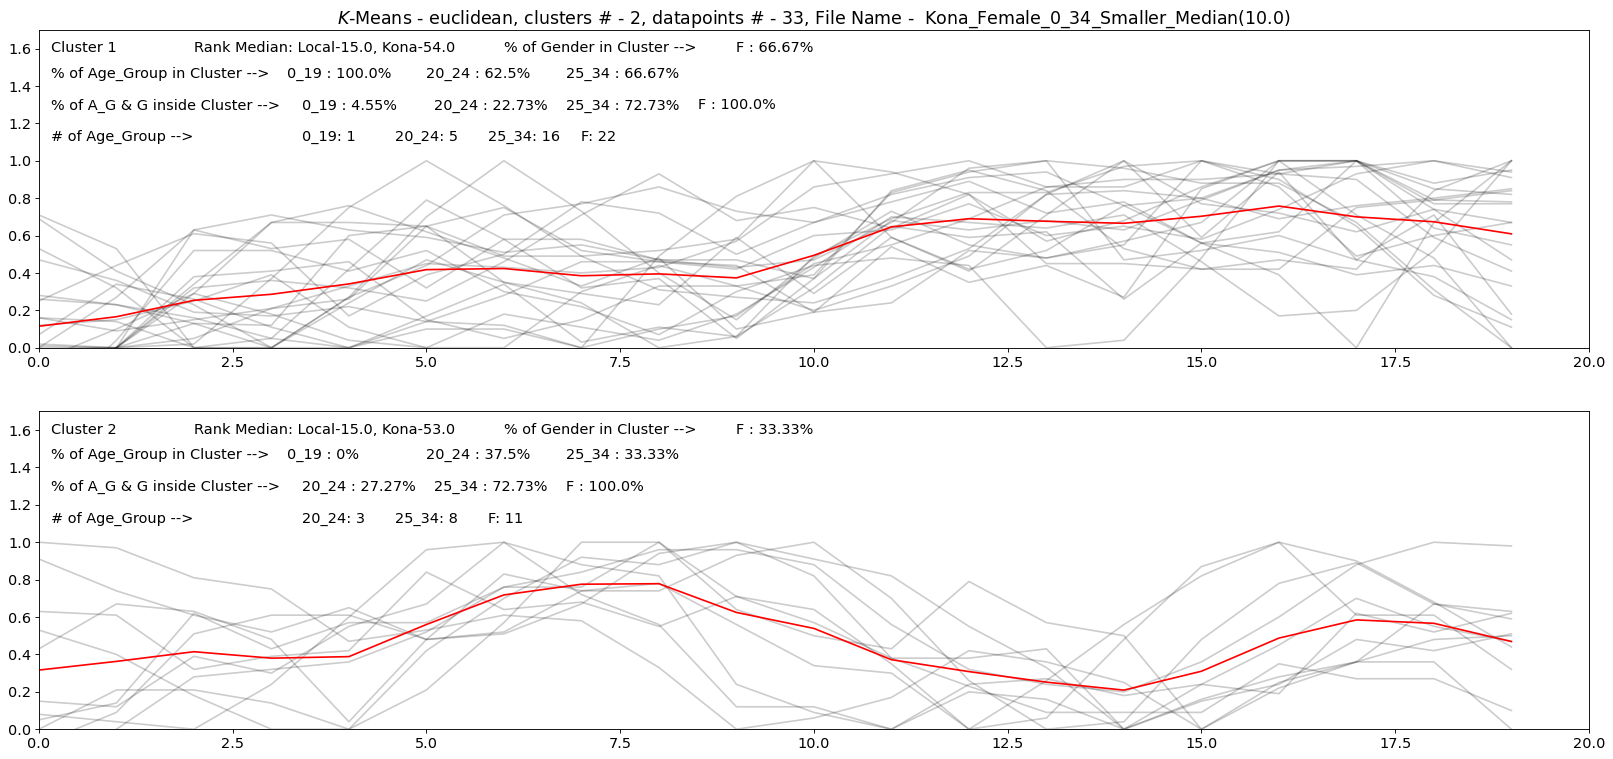

In [0]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(25, 100), dpi=80, facecolor='w', edgecolor='k')
plt.rc('font', size=13)  

for yi in range(number_of_clusters):
    plt.subplot(16, 1, 1 + yi)
    for xx in clusteredArray[yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(a.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, 1.7)

   

    ### Cluster #
    plt.text(0.008, 0.93,  'Cluster %d' % (yi + 1), transform=plt.gca().transAxes)

    ### Ranks
    plt.text(0.1, 0.93,  'Rank Median:{}-{},{}-{}'.format(" Local",medianRankForClustersLocal[yi]," Kona", medianRankForClustersKona[yi]),transform=plt.gca().transAxes)


     ### Gender Percentages
    plt.text(0.3, 0.93,  '{}'.format('% of Gender in Cluster -->'), transform=plt.gca().transAxes)
    for index,part in enumerate(arrayOfPercentage[yi]):
        plt.text(0.45 + (index*0.05), 0.93,  '{} : {}{}'.format(part[0], round(part[1].astype(float),2), '%'), transform=plt.gca().transAxes)


    ### Age Percentages all
    plt.text(0.008, 0.85,  '{}'.format('% of Age_Group in Cluster -->'), transform=plt.gca().transAxes)
    for index,age in enumerate(unique_ages):
      plt.text(0.16+(index*0.090), 0.85,  '{} : {}'.format(age, percentageOfAgeGroups[index][yi] if yi < len(percentageOfAgeGroups[index]) else "0%"), transform=plt.gca().transAxes)

   ### Age and Gender Percentages inside cluster
    plt.text(0.008, 0.75,  '{}'.format('% of A_G & G inside Cluster -->'), transform=plt.gca().transAxes)
    for index,array in enumerate(percentageOfAgeGroupinsideCluster[yi]):
      plt.text(0.17+(index*0.085), 0.75,  '{} : {}'.format(array[0], array[1]), transform=plt.gca().transAxes)

    ### Gender and Age numbers
    plt.text(0.008, 0.65,  '{}'.format('# of Age_Group -->'), transform=plt.gca().transAxes)
    for index, meta in enumerate(arrayofMeta[yi]):
      plt.text(0.17 + (0.06 * index), 0.65, '{}: {}'.format(meta[0], meta[1]),
             transform=plt.gca().transAxes)
    
    if yi == 0:
        plt.title("$K$-Means - " + metricOfClustering + ", clusters # - " + str(number_of_clusters) + ", datapoints # - " + str(len(X)) + ", File Name -  "+ title)